In [234]:
import pandas as pd
import numpy as np
import json
from scipy.sparse import csr_matrix, identity
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score
from sklearn.metrics import accuracy_score, f1_score
import itertools
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [ ]:
cards = pd.read_csv('/Users/manyuhaochi/Desktop/DSA3101/archive-2/cards_data.csv')
transactions = pd.read_csv('/Users/manyuhaochi/Desktop/DSA3101/archive-2/transactions_data.csv')
users = pd.read_csv('/Users/manyuhaochi/Desktop/DSA3101/archive-2/users_data.csv')

In [84]:
cards['credit_limit']= cards['credit_limit'].replace({'\$': ''}, regex=True).astype(float)
cards.drop(columns=cards.loc[:,'acct_open_date':'card_on_dark_web'], inplace=True)
cards.drop(columns=cards.loc[:,'card_number':'num_cards_issued'], inplace=True)
cards.head()

,id,client_id,card_brand,card_type,credit_limit
0,4524,825,Visa,Debit,24295.0
1,2731,825,Visa,Debit,21968.0
2,3701,825,Visa,Debit,46414.0
3,42,825,Visa,Credit,12400.0
4,4659,825,Mastercard,Debit (Prepaid),28.0


In [85]:
# print(cards.shape) #(6146, 13)
missing_values = cards.isnull().sum()
missing_values

id              0
client_id       0
card_brand      0
card_type       0
credit_limit    0
dtype: int64

In [98]:
cards_new = cards.groupby(['client_id', 'card_type'])['credit_limit'].sum().reset_index()
cards_new = cards_new.pivot(index='client_id', columns='card_type', values='credit_limit').fillna(0).reset_index()
#cards_new.drop('card_type',axis = "index", inplace=True)
cards_new.head(20)

card_type,client_id,Credit,Debit,Debit (Prepaid)
0,0,17600.0,88056.0,0.0
1,1,23700.0,18105.0,0.0
2,2,15200.0,35161.0,0.0
3,3,0.0,13515.0,207.0
4,4,19300.0,116902.0,0.0
5,5,0.0,31180.0,0.0
6,6,14600.0,0.0,0.0
7,7,0.0,34142.0,25.0
8,8,25700.0,0.0,0.0
9,9,7600.0,16719.0,0.0


In [101]:
print(cards_new.columns)
print(cards_new.columns.name)
cards_new.rename_axis(None, axis='columns', inplace=True)
cards_new.head()

Index(['client_id', 'Credit', 'Debit', 'Debit (Prepaid)'], dtype='object')
None


,client_id,Credit,Debit,Debit (Prepaid)
0,0,17600.0,88056.0,0.0
1,1,23700.0,18105.0,0.0
2,2,15200.0,35161.0,0.0
3,3,0.0,13515.0,207.0
4,4,19300.0,116902.0,0.0


In [37]:
users.head()
# print(users.shape)#(2000, 14)
missing_values = users.isnull().sum()
missing_values

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

In [113]:
users.drop(columns=['address','per_capita_income'], inplace=True)
users.loc[:,"yearly_income":"total_debt"]=users.loc[:,"yearly_income":"total_debt"].apply(lambda x: x.replace({'\$': ''}, regex=True).astype(float))
users.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,34.15,-117.76,59696.0,127613.0,787,5
1,1746,53,68,1966,12,Female,40.76,-73.74,77254.0,191349.0,701,5
2,1718,81,67,1938,11,Female,34.02,-117.89,33483.0,196.0,698,5
3,708,63,63,1957,1,Female,40.71,-73.99,249925.0,202328.0,722,4
4,1164,43,70,1976,9,Male,37.76,-122.44,109687.0,183855.0,675,1


In [114]:
users['gender'] = users['gender'].apply(lambda x: 1 if x == 'Male' else 0)
users.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,0,34.15,-117.76,59696.0,127613.0,787,5
1,1746,53,68,1966,12,0,40.76,-73.74,77254.0,191349.0,701,5
2,1718,81,67,1938,11,0,34.02,-117.89,33483.0,196.0,698,5
3,708,63,63,1957,1,0,40.71,-73.99,249925.0,202328.0,722,4
4,1164,43,70,1976,9,1,37.76,-122.44,109687.0,183855.0,675,1


In [126]:
final_df = pd.merge(users, cards_new, left_on='id', right_on='client_id', how='inner').sort_values('id').reset_index(drop=True)
final_df.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards,client_id,Credit,Debit,Debit (Prepaid)
0,0,33,69,1986,3,1,43.59,-70.33,59613.0,36199.0,763,4,0,17600.0,88056.0,0.0
1,1,43,74,1976,4,0,30.44,-87.18,45360.0,14587.0,704,3,1,23700.0,18105.0,0.0
2,2,48,64,1971,8,1,40.84,-73.87,27447.0,80850.0,673,5,2,15200.0,35161.0,0.0
3,3,49,65,1970,12,1,33.89,-98.51,27943.0,18693.0,681,4,3,0.0,13515.0,207.0
4,4,54,72,1965,3,0,47.61,-122.30,76431.0,115362.0,716,5,4,19300.0,116902.0,0.0


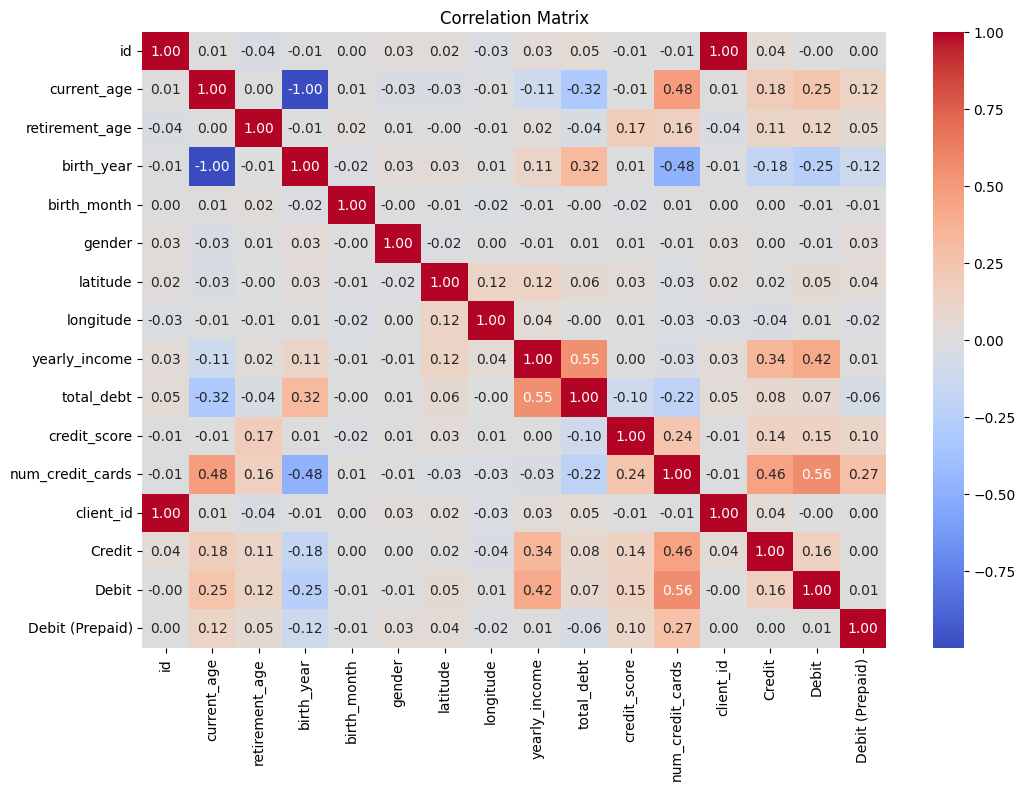

In [ ]:
correlation_matrix = final_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [128]:
final_df.drop(columns=['client_id','birth_year'], inplace=True)

In [129]:
final_df.head() 

,id,current_age,retirement_age,birth_month,gender,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards,Credit,Debit,Debit (Prepaid)
0,0,33,69,3,1,43.59,-70.33,59613.0,36199.0,763,4,17600.0,88056.0,0.0
1,1,43,74,4,0,30.44,-87.18,45360.0,14587.0,704,3,23700.0,18105.0,0.0
2,2,48,64,8,1,40.84,-73.87,27447.0,80850.0,673,5,15200.0,35161.0,0.0
3,3,49,65,12,1,33.89,-98.51,27943.0,18693.0,681,4,0.0,13515.0,207.0
4,4,54,72,3,0,47.61,-122.30,76431.0,115362.0,716,5,19300.0,116902.0,0.0


In [38]:
transactions.head(50)
# print(transactions.shape) #(13305915, 12)
missing_values = transactions.isnull().sum()
missing_values

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64

In [135]:
transactions["date"] = pd.to_datetime(transactions["date"])
start_date = "2018-11-01"
end_date = "2019-11-01"

tran_df = transactions[(transactions["date"] >= start_date) & (transactions["date"] <= end_date)]

tran_df.head(10)

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
11912975,22038356,2018-11-01 00:00:00,316,2038,$91.31,Chip Transaction,75781,Houston,TX,77051.0,5411,Insufficient Balance
11912976,22038357,2018-11-01 00:02:00,637,2981,$8.77,Chip Transaction,30928,Saint Cloud,MN,56301.0,5541,NaN
11912977,22038358,2018-11-01 00:04:00,316,5857,$78.08,Chip Transaction,75781,Houston,TX,77051.0,5411,NaN
11912978,22038359,2018-11-01 00:06:00,554,2308,$4.02,Chip Transaction,60939,La Porte,TX,77571.0,5211,NaN
11912979,22038360,2018-11-01 00:06:00,1129,102,$80.00,Chip Transaction,27092,Vista,CA,92084.0,4829,NaN
11912980,22038361,2018-11-01 00:06:00,1697,3023,$0.33,Chip Transaction,60440,Clinton Township,MI,48038.0,5411,NaN
11912981,22038362,2018-11-01 00:09:00,561,2716,$11.00,Swipe Transaction,4239,Burlington,IA,52601.0,5655,NaN
11912982,22038363,2018-11-01 00:09:00,1556,2972,$-74.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
11912983,22038364,2018-11-01 00:09:00,1797,299,$46.32,Online Transaction,18563,ONLINE,NaN,NaN,4121,NaN
11912984,22038365,2018-11-01 00:12:00,98,4143,$86.88,Chip Transaction,20561,Tilton,IL,61833.0,5912,NaN


## Remove errorneous transactions

In [139]:
tran_df = tran_df[tran_df['errors'].isna()]
tran_df.shape

(1370654, 12)

In [24]:
# Load the JSON file
with open("/Users/manyuhaochi/Desktop/DSA3101/archive-2/mcc_codes.json", "r") as f:
    data = json.load(f)
data

{'5812': 'Eating Places and Restaurants',
 '5541': 'Service Stations',
 '7996': 'Amusement Parks, Carnivals, Circuses',
 '5411': 'Grocery Stores, Supermarkets',
 '4784': 'Tolls and Bridge Fees',
 '4900': 'Utilities - Electric, Gas, Water, Sanitary',
 '5942': 'Book Stores',
 '5814': 'Fast Food Restaurants',
 '4829': 'Money Transfer',
 '5311': 'Department Stores',
 '5211': 'Lumber and Building Materials',
 '5310': 'Discount Stores',
 '3780': 'Computer Network Services',
 '5499': 'Miscellaneous Food Stores',
 '4121': 'Taxicabs and Limousines',
 '5300': 'Wholesale Clubs',
 '5719': 'Miscellaneous Home Furnishing Stores',
 '7832': 'Motion Picture Theaters',
 '5813': 'Drinking Places (Alcoholic Beverages)',
 '4814': 'Telecommunication Services',
 '5661': 'Shoe Stores',
 '5977': 'Cosmetic Stores',
 '8099': 'Medical Services',
 '7538': 'Automotive Service Shops',
 '5912': 'Drug Stores and Pharmacies',
 '4111': 'Local and Suburban Commuter Transportation',
 '5815': 'Digital Goods - Media, Books,

In [52]:
subgroup_mapping = {"Freight & Trucking": ["3730", "4214"],
    "Steel & Metal Products": ["3000", "3001", "3005", "3006", "3007", "3008", "3009",
                                 "3359", "3387", "3389", "3390", "3393", "3395", "3405", "5094"],
    "Retail Stores": ["5300", "5310", "5311", "5411", "5499","5193","3260"],
    "Digital Goods & Computers": ["5815", "5816", "5045"],
    "Utilities & Home Services": ["4900", "7210", "7349", "1711","5719","5712","3174","3144"],

    "Machinery & Tools": ["3058", "3066", "3075", "3504", "3509", "3596","5211","5261","3256"],
    
    "Rail & Bus Transport": ["3722", "3771", "3775", "4111", "4112", "4121", "4131", "4784", "3780"],
    
    "Telecommunications & Media": ["4814", "4829", "4899"],

    "Electronics & Appliances": ["3640","3684","5732","5251","5722"],
    "Automotive & Transportation Services": ["5533", "5541", "7531", "7538", "7542", "7549"],
    
    "Restaurants & Eating Places": ["5812", "5813", "5814"],
    
    "Clothing & Fashion": ["5621", "5651", "5655", "5661", "5977", "5932", "5947", "7230","3132"],
    
    "Movies & Theaters": ["7832", "7922", "5192", "5942"],
    "Sports & Recreational Activities": ["7801", "7802", "5941", "5970","7996","7995","5733"],
    
    "Medical & Healthcare Services": ["8011", "8021", "8041", "8043", "8049", "8062", "8099", "5912", "5921"],
    
    "Legal & Financial Services": ["8111", "8931", "7276", "7393","6300"],
    
    "Hotels & Accommodation": ["7011", "4411", "4511", "4722"],
    
    "Postal Services - Government Only": ["9402"],
}

# Create a reverse lookup: map each code to its category (subgroup)
code_to_category = {}
for category, codes in subgroup_mapping.items():
    for code in codes:
        code_to_category[code] = category

# Step 3: Prepare the CSV data
# The CSV will have three columns: Code, Product, Category
csv_rows = []
header = ["Code", "Product", "Category"]
csv_rows.append(header)

for code, product in data.items():
    # Use the category from our mapping; if a code isn't found, assign "Uncategorized"
    category = code_to_category.get(code, "Uncategorized")
    csv_rows.append([code, product, category])

# Step 4: Write the CSV file
with open("output.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(csv_rows)

print("CSV file 'output.csv' has been created with assigned categories.")


CSV file 'output.csv' has been created with assigned categories.


In [220]:
merged_trans = pd.merge(tran_df, output, left_on='mcc', right_on='Code', how='left')
merged_trans.value_counts('client_id')


client_id
1098    4848
1963    4381
1776    4268
909     4232
114     3972
        ... 
1002     339
19       316
1749     293
1016     223
1649     210
Name: count, Length: 1206, dtype: int64

In [ ]:
merged_trans['amount'] = merged_trans['amount'].replace({'\$': ''}, regex=True).astype(float)
category_spend = merged_trans.groupby(['client_id', 'Category'])['amount'].sum().reset_index()
category_spend.head()

,client_id,Category,amount
0,0,Automotive & Transportation Services,5605.50
1,0,Clothing & Fashion,1915.53
2,0,Digital Goods & Computers,664.27
3,0,Electronics & Appliances,568.06
4,0,Freight & Trucking,284.24


In [146]:
spending = category_spend.pivot(index='client_id', columns='Category', values='amount').fillna(0).reset_index()

In [158]:
final = pd.merge(final_df, spending, left_on='id', right_on='client_id', how='left')

In [221]:
#final.drop(columns=['client_id','id'], inplace=True)
final.head()

,current_age,retirement_age,birth_month,gender,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards,...,Medical & Healthcare Services,Movies & Theaters,Postal Services - Government Only,Rail & Bus Transport,Restaurants & Eating Places,Retail Stores,Sports & Recreational Activities,Steel & Metal Products,Telecommunications & Media,Utilities & Home Services
0,33,69,3,1,43.59,-70.33,59613.0,36199.0,763,4,...,3140.13,808.03,296.44,1415.70,12778.17,13124.77,693.76,1237.11,6265.45,6114.08
1,43,74,4,0,30.44,-87.18,45360.0,14587.0,704,3,...,2280.52,507.43,0.00,8505.69,2655.97,3479.84,0.00,299.26,6291.66,3002.74
2,48,64,8,1,40.84,-73.87,27447.0,80850.0,673,5,...,2655.42,873.73,1618.69,660.48,0.00,8383.81,816.51,0.00,2755.43,2414.89
3,49,65,12,1,33.89,-98.51,27943.0,18693.0,681,4,...,4924.26,72.39,0.00,1048.72,371.52,12570.14,6.76,980.88,662.82,1860.70
4,54,72,3,0,47.61,-122.30,76431.0,115362.0,716,5,...,4871.89,2037.63,22.68,281.70,19560.77,7666.37,1075.61,245.37,8251.47,3114.92


In [ ]:
def evaluate_knn_imputer_scaled_transform_original(n_neighbors, data, target_cols, mask_frac=0.1, random_state=42):
    mse_list = []
    # Work on a copy so that modifications for one column do not affect the others.
    data_copy = data.copy()
    np.random.seed(random_state)
    
    for col in target_cols:
        non_missing_idx = data_copy[data_copy[col].notnull()].index
        if len(non_missing_idx) == 0:
            continue
        
        # Randomly mask a fraction of non-missing values
        mask_idx = np.random.choice(non_missing_idx, 
                                     size=int(mask_frac * len(non_missing_idx)), 
                                     replace=False)
        original_values = data_copy.loc[mask_idx, col].copy()
        data_copy.loc[mask_idx, col] = np.nan
        
        # Build a pipeline: Standardize then impute
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('imputer', KNNImputer(n_neighbors=n_neighbors))
        ])
        
        imputed_array = pipeline.fit_transform(data_copy)
        imputed_df = pd.DataFrame(imputed_array, columns=data_copy.columns, index=data_copy.index)
        
        # Retrieve the fitted scaler to manually scale original values
        fitted_scaler = pipeline.named_steps['scaler']
        col_index = list(data_copy.columns).index(col)
        
        # Scale the original (masked) values using the fitted scaler parameters
        original_values_scaled = (original_values - fitted_scaler.mean_[col_index]) / fitted_scaler.scale_[col_index]
        imputed_values_scaled = imputed_df.loc[mask_idx, col]
        
        mse = mean_squared_error(original_values_scaled, imputed_values_scaled)
        mse_list.append(mse)
        
        # Restore original values so the next iteration works on unmodified data_copy
        data_copy.loc[mask_idx, col] = original_values
        
    return np.mean(mse_list)

n_neighbors = 2, MSE (standardized) = 1.0932669897406093
n_neighbors = 3, MSE (standardized) = 0.9806865784719191
n_neighbors = 4, MSE (standardized) = 0.9334839974919854
n_neighbors = 5, MSE (standardized) = 0.918080744850026
n_neighbors = 6, MSE (standardized) = 0.9075961060392205
n_neighbors = 7, MSE (standardized) = 0.9052972561287649
n_neighbors = 8, MSE (standardized) = 0.9054410855257219
n_neighbors = 9, MSE (standardized) = 0.8962341481103304
n_neighbors = 10, MSE (standardized) = 0.8981124647019928


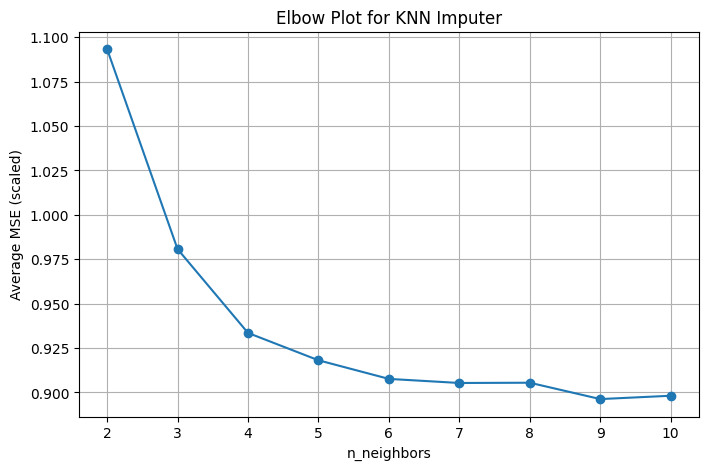

In [ ]:
target_cols = ['Automotive & Transportation Services', 'Clothing & Fashion',
       'Digital Goods & Computers', 'Electronics & Appliances',
       'Freight & Trucking', 'Hotels & Accommodation',
       'Legal & Financial Services', 'Machinery & Tools',
       'Medical & Healthcare Services', 'Movies & Theaters',
       'Postal Services - Government Only', 'Rail & Bus Transport',
       'Restaurants & Eating Places', 'Retail Stores',
       'Sports & Recreational Activities', 'Steel & Metal Products',
       'Telecommunications & Media', 'Utilities & Home Services']

# List of feature columns used for imputation
feature_cols = ['current_age', 'retirement_age', 'birth_month', 'gender',
       'latitude', 'longitude', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'Credit', 'Debit', 'Debit (Prepaid)']

# Create a working DataFrame with both feature and target columns.
# (Assuming you have a DataFrame called 'final' already loaded.)
cols_for_impute = feature_cols + target_cols
df_impute = final[cols_for_impute].copy()

# Evaluate a range of n_neighbors (e.g., 2 to 10) and record the MSE for each.
results_scaled = {}
ks = list(range(2, 11))
for k in ks:
    mse = evaluate_knn_imputer_scaled_transform_original(k, df_impute, target_cols, mask_frac=0.1, random_state=42)
    results_scaled[k] = mse
    print(f"n_neighbors = {k}, MSE (standardized) = {mse}")

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(ks, [results_scaled[k] for k in ks], marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('Average MSE (scaled)')
plt.title('Elbow Plot for KNN Imputer')
plt.grid(True)
plt.show()



In [181]:
# Select the best n_neighbors (with the lowest MSE)
best_n = 5
print("Best n_neighbors (standardized):", best_n)

# Build final pipeline and impute missing values using the best n_neighbors.
pipeline_final = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=best_n))
])
imputed_array = pipeline_final.fit_transform(df_impute)
# Save the imputed & scaled DataFrame.
df_imputed_scaled = pd.DataFrame(imputed_array, columns=df_impute.columns, index=df_impute.index)
print("Head of imputed and scaled data:")
print(df_imputed_scaled.head())

Best n_neighbors (standardized): 5
Head of imputed and scaled data:
   current_age  retirement_age  birth_month    gender  latitude  longitude  \
0    -0.673104        0.761447    -0.964806  1.016130  1.212736   1.303795   
1    -0.129906        2.139632    -0.684258 -0.984126 -1.359117   0.268733   
2     0.141693       -0.616738     0.437936  1.016130  0.674896   1.086340   
3     0.196013       -0.341101     1.560130  1.016130 -0.684372  -0.427246   
4     0.467612        1.588358    -0.964806 -0.984126  1.998960  -1.888618   

   yearly_income  total_debt  credit_score  num_credit_cards  ...  \
0       0.604568   -0.526607      0.792581          0.566290  ...   
1      -0.015482   -0.940302     -0.085328         -0.044595  ...   
2      -0.794753    0.328098     -0.546603          1.177175  ...   
3      -0.773175   -0.861706     -0.427564          0.566290  ...   
4       1.336203    0.988724      0.093229          1.177175  ...   

   Medical & Healthcare Services  Movies & Theat

In [187]:
scaler = pipeline_final.named_steps['scaler']
# Inverse-transform the imputed scaled data.
df_imputed_original_array = scaler.inverse_transform(df_imputed_scaled)
df_imputed_original = pd.DataFrame(df_imputed_original_array, columns=df_impute.columns, index=df_impute.index)
print("Head of imputed data in original scale:")
df_imputed_original.head(10)

Head of imputed data in original scale:


,current_age,retirement_age,birth_month,gender,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards,...,Medical & Healthcare Services,Movies & Theaters,Postal Services - Government Only,Rail & Bus Transport,Restaurants & Eating Places,Retail Stores,Sports & Recreational Activities,Steel & Metal Products,Telecommunications & Media,Utilities & Home Services
0,33.0,69.0,3.0,1.0,43.59,-70.33,59613.0,36199.0,763.0,4.0,...,3140.130,808.030,2.964400e+02,1415.700,12778.170,13124.770,6.937600e+02,1237.110,6265.450,6114.080
1,43.0,74.0,4.0,0.0,30.44,-87.18,45360.0,14587.0,704.0,3.0,...,2280.520,507.430,-1.421085e-14,8505.690,2655.970,3479.840,2.273737e-13,299.260,6291.660,3002.740
2,48.0,64.0,8.0,1.0,40.84,-73.87,27447.0,80850.0,673.0,5.0,...,2655.420,873.730,1.618690e+03,660.480,0.000,8383.810,8.165100e+02,0.000,2755.430,2414.890
3,49.0,65.0,12.0,1.0,33.89,-98.51,27943.0,18693.0,681.0,4.0,...,4924.260,72.390,-1.421085e-14,1048.720,371.520,12570.140,6.760000e+00,980.880,662.820,1860.700
4,54.0,72.0,3.0,0.0,47.61,-122.30,76431.0,115362.0,716.0,5.0,...,4871.890,2037.630,2.268000e+01,281.700,19560.770,7666.370,1.075610e+03,245.370,8251.470,3114.920
5,65.0,65.0,2.0,1.0,42.95,-77.13,20614.0,14042.0,711.0,2.0,...,4236.320,625.150,-1.421085e-14,571.570,905.850,2751.480,8.794000e+01,1.910,5767.950,6020.500
6,19.0,63.0,6.0,0.0,32.88,-117.13,55854.0,111042.0,782.0,1.0,...,4043.262,1429.452,4.908000e+00,2314.898,3094.864,10994.768,5.895620e+03,524.828,7603.972,2924.472
7,74.0,61.0,5.0,1.0,39.30,-76.61,32682.0,21379.0,650.0,3.0,...,2562.680,380.332,7.786000e+00,5919.524,1251.382,5710.014,3.264680e+02,320.888,5873.650,3594.442
8,21.0,69.0,8.0,1.0,27.95,-82.48,38497.0,33413.0,699.0,2.0,...,3768.570,330.178,4.291120e+02,1797.932,1908.238,8773.008,1.315340e+02,568.586,5738.662,2761.140
9,29.0,60.0,12.0,1.0,32.63,-117.05,40988.0,89801.0,540.0,3.0,...,4222.776,918.794,8.651800e+01,3863.376,1823.630,10758.208,5.769520e+02,593.246,9236.158,3073.352


In [194]:
income_median = df_imputed_original['yearly_income'].median()
num_cards_median = df_imputed_original['num_credit_cards'].median()
credit_upper = df_imputed_original['credit_score'].quantile(0.75)
income_80 = df_imputed_original['yearly_income'].quantile(0.80)  

# For each spending category used in the rules, compute its 75th percentile.
spending_categories = [
    'Retail Stores', 'Restaurants & Eating Places', 'Clothing & Fashion', 
    'Movies & Theaters', 'Sports & Recreational Activities', 'Freight & Trucking', 
    'Medical & Healthcare Services', 'Postal Services - Government Only', 
    'Digital Goods & Computers', 'Telecommunications & Media', 'Utilities & Home Services', 
    'Automotive & Transportation Services', 'Steel & Metal Products', 'Machinery & Tools', 
    'Rail & Bus Transport', 'Hotels & Accommodation', 'Legal & Financial Services'
]
spending_upper = {cat: df_imputed_original[cat].quantile(0.75) for cat in spending_categories}

In [196]:
def label_rewards_credit_card(row):
    score = 0
    cats = ['Retail Stores', 'Restaurants & Eating Places', 'Clothing & Fashion', 
            'Movies & Theaters', 'Sports & Recreational Activities']
    if any(row[cat] >= spending_upper[cat] for cat in cats):
        score += 1
    if row['credit_score'] >= credit_upper:
        score += 1
    if row['num_credit_cards'] >= num_cards_median:
        score += 1
    return min(score, 3)

def label_insurance_solutions(row):
    score = 0
    cats = ['Freight & Trucking', 'Medical & Healthcare Services', 'Postal Services - Government Only']
    if any(row[cat] >= spending_upper[cat] for cat in cats):
        score += 1
    credit_median = df_imputed_original['credit_score'].quantile(0.50)
    credit_80 = df_imputed_original['credit_score'].quantile(0.80)
    if credit_median < row['credit_score'] <= credit_80:
        score += 1
    if row['yearly_income'] >= income_median:
        score += 1
    return min(score, 3)

# 3. Digital Financing:
#    Conditions: (a) any spending category above its upper quantile,
#                (b) yearly income above median,
#                (c) credit score above upper quantile.
def label_digital_financing(row):
    score = 0
    cats = ['Digital Goods & Computers', 'Telecommunications & Media']
    if any(row[cat] >= spending_upper[cat] for cat in cats):
        score += 1
    if row['yearly_income'] >= income_median:
        score += 1
    if row['credit_score'] >= credit_upper:
        score += 1
    return min(score, 3)

# 4. Home Improvement Loan (loan-related):
#    Conditions: Credit score must exceed upper quantile (else 0),
#                (a) spending in Utilities & Home Services above its upper quantile,
#                (b) yearly income above median.
def label_home_improvement_loan(row):
    score = 0 
    if row['credit_score'] >= credit_upper:
        score += 1
    if row['Utilities & Home Services'] >= spending_upper['Utilities & Home Services']:
        score += 1
    if row['yearly_income'] >= income_median:
        score += 1
    return min(score, 3)

# 5. Auto & Vehicle Financing (loan-related):
#    Conditions: Credit score must exceed upper quantile,
#                (a) spending in Automotive & Transportation Services above its upper quantile,
#                (b) yearly income above median.
def label_auto_vehicle_financing(row):
    score = 0 # Base point for meeting credit requirement
    if row['credit_score'] >= credit_upper:
        score += 1
    if row['Automotive & Transportation Services'] >= spending_upper['Automotive & Transportation Services']:
        score += 1
    if row['yearly_income'] >= income_median:
        score += 1
    return min(score, 3)

# 6. Commodity & Investment Services:
#    Conditions: (a) any spending category (Steel & Metal Products or Machinery & Tools) above its upper quantile,
#                (b) yearly income above median,
#                (c) low total debt relative to income (total_debt < 0.5*yearly_income).
def label_commodity_investment_services(row):
    score = 0
    cats = ['Steel & Metal Products', 'Machinery & Tools']
    if any(row[cat] >= spending_upper[cat] for cat in cats):
        score += 1
    if row['yearly_income'] >= income_80:
        score += 1
    if row['total_debt'] <= 0.5 * row['yearly_income']:
        score += 1
    return min(score, 3)

# 7. Travel Rewards Card:
#    Conditions: (a) any spending category (Rail & Bus Transport or Hotels & Accommodation) above its upper quantile,
#                (b) yearly income above median,
#                (c) number of credit cards above median.
def label_travel_rewards_card(row):
    score = 0
    cats = ['Rail & Bus Transport', 'Hotels & Accommodation']
    if any(row[cat] >= spending_upper[cat] for cat in cats):
        score += 1
    if row['yearly_income'] >= income_median:
        score += 1
    if row['num_credit_cards'] >= num_cards_median:
        score += 1
    return min(score, 3)

# 8. Savings/Investment Plans:
#    Conditions remain unchanged.
def label_savings_investment_plans(row):
    score = 0
    if row['Debit'] >= 1.5 * row['Credit']:
        score += 1
    if row['total_debt'] < 0.5 * row['yearly_income']:
        score += 1
    if row['retirement_age'] - row['current_age'] <= 15:
        score += 1
    return min(score, 3)

# 9. Wealth Management & Savings:
#    Conditions: (a) spending in Legal & Financial Services above its upper quantile,
#                (b) yearly income above median and low total debt,
#                (c) credit score above upper quantile.
def label_wealth_management_savings(row):
    score = 0
    if row['Legal & Financial Services'] >= spending_upper['Legal & Financial Services']:
        score += 1
    if row['yearly_income'] >= income_80 and row['total_debt'] < 0.5 * row['yearly_income']:
        score += 1
    if row['credit_score'] >= credit_upper:
        score += 1
    return min(score, 3)



In [197]:
# Apply label functions to construct new label columns.
df_imputed_original['Label_Rewards_Credit_Card'] = df_imputed_original.apply(label_rewards_credit_card, axis=1)
df_imputed_original['Label_Insurance_Solutions'] = df_imputed_original.apply(label_insurance_solutions, axis=1)
df_imputed_original['Label_Digital_Financing'] = df_imputed_original.apply(label_digital_financing, axis=1)
df_imputed_original['Label_Home_Improvement_Loan'] = df_imputed_original.apply(label_home_improvement_loan, axis=1)
df_imputed_original['Label_Auto_Vehicle_Financing'] = df_imputed_original.apply(label_auto_vehicle_financing, axis=1)
df_imputed_original['Label_Commodity_Investment_Services'] = df_imputed_original.apply(label_commodity_investment_services, axis=1)
df_imputed_original['Label_Travel_Rewards_Card'] = df_imputed_original.apply(label_travel_rewards_card, axis=1)
df_imputed_original['Label_Savings_Investment_Plans'] = df_imputed_original.apply(label_savings_investment_plans, axis=1)
df_imputed_original['Label_Wealth_Management_Savings'] = df_imputed_original.apply(label_wealth_management_savings, axis=1)

print("Sample label counts:")
df_imputed_original[['Label_Rewards_Credit_Card', 'Label_Insurance_Solutions',
                           'Label_Digital_Financing', 'Label_Home_Improvement_Loan',
                           'Label_Auto_Vehicle_Financing', 'Label_Commodity_Investment_Services',
                           'Label_Travel_Rewards_Card', 'Label_Savings_Investment_Plans',
                           'Label_Wealth_Management_Savings']].head()

Sample label counts:


,Label_Rewards_Credit_Card,Label_Insurance_Solutions,Label_Digital_Financing,Label_Home_Improvement_Loan,Label_Auto_Vehicle_Financing,Label_Commodity_Investment_Services,Label_Travel_Rewards_Card,Label_Savings_Investment_Plans,Label_Wealth_Management_Savings
0,3,3,3,3,3,2,3,1,1
1,2,1,1,1,1,1,3,1,0
2,1,1,0,0,0,0,1,1,1
3,2,0,1,0,0,0,1,1,0
4,2,2,2,1,1,1,2,1,1


In [ ]:
def compute_top3_accuracy_for_fold(model, X_val, interactions_val, item_features, k=3):
    num_users = X_val.shape[0]
    top3_acc = []
    for user_id in range(num_users):
        # Predict scores for all items for this user.
        scores = model.predict(user_id, np.arange(interactions_val.shape[1]),
                               user_features=X_val,
                               item_features=item_features)
        # Get top k indices
        top3_indices = np.argsort(-scores)[:k]
        # Get true purchased product indices (true positive if value==1)
        true_positives = set(np.where(interactions_val[user_id].toarray().flatten() == 1)[0])
        n_true = len(true_positives)
        if n_true == 0:
            # In a real bank scenario, you might choose to ignore these users;
            # here we assign 0 accuracy.
            top3_acc.append(0)
        elif n_true >= 3:
            # If user purchased 3 or more, accuracy = (# in top3) / 3.
            count = len(set(top3_indices).intersection(true_positives))
            top3_acc.append(count / 3.0)
        elif n_true == 2:
            # If user purchased exactly 2 items.
            intersection = set(top3_indices).intersection(true_positives)
            if len(intersection) == 2:
                top3_acc.append(1.0)
            elif len(intersection) == 1:
                top3_acc.append(0.5)
            else:
                top3_acc.append(0)
        elif n_true == 1:
            # For a single true purchase.
            if top3_indices[0] in true_positives:
                top3_acc.append(1.0)
            elif len(set(top3_indices[1:]).intersection(true_positives)) > 0:
                top3_acc.append(0.5)
            else:
                top3_acc.append(0)
    return np.mean(top3_acc)


In [ ]:
def grid_search_cv(feature_list, X_train_full, Y_train_bin):
    # Extract the features from X_train_full based on the provided feature list.
    X_train_features = X_train_full[feature_list].copy()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    user_features = csr_matrix(X_train_scaled)
    
    # Build the interaction matrix from Y_train_bin.
    interactions = csr_matrix(Y_train_bin.values)
    num_items = interactions.shape[1]
    item_features = identity(num_items, format='csr')
    
    # Define hyperparameter grid.
    param_grid = {
        'loss': ['warp', 'bpr','logistic'],
        'no_components': [16, 32, 64],
        'learning_rate': [0.001, 0.01, 0.05],
        'epochs': [30, 50],
        'user_alpha': [1e-5, 1e-4],
        'item_alpha': [1e-5, 1e-4]
    }
    
    # Set up 5-fold CV.
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_results = []
    upsample_factor = 2

    for loss, no_components, learning_rate, epochs, user_alpha, item_alpha in itertools.product(
        param_grid['loss'],
        param_grid['no_components'],
        param_grid['learning_rate'],
        param_grid['epochs'],
        param_grid['user_alpha'],
        param_grid['item_alpha']
    ):
        fold_top3_acc = []
        fold_prec = []
        fold_f1_micro = []
        fold_f1_macro = []

        for train_idx, val_idx in kf.split(user_features):
            X_train_cv = user_features[train_idx]
            X_val_cv = user_features[val_idx]
            
            # Get the training interactions for this fold.
            fold_train = interactions[train_idx].toarray().astype(float)
            
            # Upsample the minority class for each product column in the training fold.
            for j in range(fold_train.shape[1]):
                pos_count = np.sum(fold_train[:, j] == 1)
                neg_count = np.sum(fold_train[:, j] == 0)
                if pos_count / fold_train.shape[0] < 0.3:
                    fold_train[:, j] = np.where(fold_train[:, j] == 1,
                                                fold_train[:, j] * upsample_factor,
                                                fold_train[:, j])
                elif neg_count / fold_train.shape[0] < 0.3:
                    fold_train[:, j] = np.where(fold_train[:, j] == 0,
                                                fold_train[:, j] * upsample_factor,
                                                fold_train[:, j])
            fold_train_sparse = csr_matrix(fold_train)
            
            # Validation interactions (untouched).
            fold_val = interactions[val_idx].toarray()
            fold_val_sparse = csr_matrix(fold_val)
            
            # Train LightFM on this fold.
            model_cv = LightFM(loss=loss, no_components=no_components,
                               learning_rate=learning_rate,
                               user_alpha=user_alpha,
                               item_alpha=item_alpha,
                               random_state=42)
            model_cv.fit(fold_train_sparse,
                         user_features=X_train_cv,
                         item_features=item_features,
                         epochs=epochs,
                         num_threads=4)
            
            # Standard precision@3.
            prec = precision_at_k(model_cv, fold_val_sparse,
                                  user_features=X_val_cv,
                                  item_features=item_features,
                                  k=3).mean()
            # Compute custom top-3 accuracy using our function.
            top3_acc = compute_top3_accuracy_for_fold(model_cv, X_val_cv, fold_val_sparse, item_features, k=3)
            
            # Get predictions from the fold for F1 and accuracy calculation.
            fold_val_scores = []
            for user_id in range(X_val_cv.shape[0]):
                scores = model_cv.predict(user_id, np.arange(num_items),
                                          user_features=X_val_cv,
                                          item_features=item_features)
                fold_val_scores.append(scores)
            fold_val_scores = np.array(fold_val_scores)
            Y_val_pred = (fold_val_scores > 0).astype(int)
            true_vals = fold_val.flatten()
            pred_vals = Y_val_pred.flatten()
            f1_micro = f1_score(true_vals, pred_vals, average='micro')
            f1_macro = f1_score(true_vals, pred_vals, average='macro')
            
            fold_top3_acc.append(top3_acc)
            fold_prec.append(prec)
            fold_f1_micro.append(f1_micro)
            fold_f1_macro.append(f1_macro)
        
        avg_top3_acc = np.mean(fold_top3_acc)
        avg_prec = np.mean(fold_prec)
        avg_f1_micro = np.mean(fold_f1_micro)
        avg_f1_macro = np.mean(fold_f1_macro)
        
        grid_results.append({
            'loss': loss,
            'no_components': no_components,
            'learning_rate': learning_rate,
            'epochs': epochs,
            'user_alpha': user_alpha,
            'item_alpha': item_alpha,
            'top3_accuracy': avg_top3_acc,
            'precision@3': avg_prec,
            'f1_micro': avg_f1_micro,
            'f1_macro': avg_f1_macro
        })
        
        print(f"Features: {feature_list} | Params: loss={loss}, components={no_components}, "
              f"lr={learning_rate}, epochs={epochs}, user_alpha={user_alpha}, item_alpha={item_alpha} -> "
              f"Top3 Accuracy: {avg_top3_acc:.4f}, Precision@3: {avg_prec:.4f}, "
              f"F1_micro: {avg_f1_micro:.4f}, F1_macro: {avg_f1_macro:.4f}")
    
    best_params = max(grid_results, key=lambda x: x['top3_accuracy'])
    return best_params, grid_results

In [ ]:
# --------------------------------------------------------------------
# Custom function to compute top-3 accuracy for a fold using our rule:
#   - If user has 3 or more purchases: accuracy = (# predicted in top3) / 3.
#   - If user has exactly 2 purchases: 1 if both in top3, 0.5 if one is, else 0.
#   - If user has exactly 1 purchase: 1 if top prediction is correct, 0.5 if in position 2 or 3, else 0.
#   - For users with no purchase, we return 0.
# --------------------------------------------------------------------
# Binarize the ordinal labels: define a "positive" interaction if label >= 2.
Y = df_imputed_original[label_cols].copy()
Y_bin = (Y >= 2).astype(int)

# Prepare user features for tuning.
# Define two feature sets:
base_features = feature_cols.copy()
expanded_features = feature_cols + target_cols  # expanded: include spending categories

# We'll try both feature sets.
feature_sets = {
    'base': base_features,
    'expanded': expanded_features
}

# Split the data into train and test (test set remains unmodified).
X = df_imputed_original.copy()  # full data
X_train_full, X_test, Y_train_bin, Y_test_bin = train_test_split(X, Y_bin, test_size=0.2, random_state=42)

print("\n--- Running grid search for feature set: expanded ---")
best_params, all_results = grid_search_cv(expanded_features, X_train_full, Y_train_bin)
print(f"Best params for expanded features: {best_params}")



--- Running grid search for feature set: expanded ---
Features: ['current_age', 'retirement_age', 'birth_month', 'gender', 'latitude', 'longitude', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards', 'Credit', 'Debit', 'Debit (Prepaid)', 'Automotive & Transportation Services', 'Clothing & Fashion', 'Digital Goods & Computers', 'Electronics & Appliances', 'Freight & Trucking', 'Hotels & Accommodation', 'Legal & Financial Services', 'Machinery & Tools', 'Medical & Healthcare Services', 'Movies & Theaters', 'Postal Services - Government Only', 'Rail & Bus Transport', 'Restaurants & Eating Places', 'Retail Stores', 'Sports & Recreational Activities', 'Steel & Metal Products', 'Telecommunications & Media', 'Utilities & Home Services'] | Params: loss=warp, components=16, lr=0.001, epochs=30, user_alpha=1e-05, item_alpha=1e-05 -> Top3 Accuracy: 0.6179, Precision@3: 0.6143, F1_micro: 0.4091, F1_macro: 0.4047
Features: ['current_age', 'retirement_age', 'birth_month', 'gender', '

In [217]:
print(best_params)

{'loss': 'warp', 'no_components': 32, 'learning_rate': 0.05, 'epochs': 50, 'user_alpha': 1e-05, 'item_alpha': 1e-05, 'top3_accuracy': 0.7444791666666667, 'precision@3': 0.72113454, 'f1_micro': 0.3302083333333333, 'f1_macro': 0.3257846244498953}


In [ ]:
def evaluate_lightfm_model(X_train_full, X_test, Y_train_bin, Y_test_bin, feature_set, best_params, label_cols):
    # Extract the selected features.
    X_train_selected = X_train_full[feature_set].copy()
    X_test_selected  = X_test[feature_set].copy()

    # Standardize features.
    scaler_final = StandardScaler()
    X_train_final = scaler_final.fit_transform(X_train_selected)
    X_test_final  = scaler_final.transform(X_test_selected)
    user_features_train_final = csr_matrix(X_train_final)
    user_features_test_final  = csr_matrix(X_test_final)

    # Build final interaction and item features.
    final_interactions_train = csr_matrix(Y_train_bin.values)
    final_interactions_test  = csr_matrix(Y_test_bin.values)
    num_items = len(label_cols)
    final_item_features = identity(num_items, format='csr')

    # Train final LightFM model using best hyperparameters.
    model_final = LightFM(loss=best_params['loss'],
                          no_components=best_params['no_components'],
                          learning_rate=best_params['learning_rate'],
                          user_alpha=best_params['user_alpha'],
                          item_alpha=best_params['item_alpha'],
                          random_state=42)

    model_final.fit(final_interactions_train,
                    user_features=user_features_train_final,
                    item_features=final_item_features,
                    epochs=best_params['epochs'],
                    num_threads=4)

    # Evaluate the final model using standard metrics.
    final_precision = precision_at_k(model_final,
                                     final_interactions_test,
                                     user_features=user_features_test_final,
                                     item_features=final_item_features,
                                     k=3).mean()
    final_auc = auc_score(model_final,
                          final_interactions_test,
                          user_features=user_features_test_final,
                          item_features=final_item_features).mean()

    # Overall binary evaluation: predict scores and threshold at 0.
    num_test_users = user_features_test_final.shape[0]
    predicted_scores_final = np.zeros((num_test_users, num_items))
    for user_id in range(num_test_users):
        predicted_scores_final[user_id, :] = model_final.predict(user_id, np.arange(num_items),
                                                                 user_features=user_features_test_final,
                                                                 item_features=final_item_features)
    Y_test_pred_final = (predicted_scores_final > 0).astype(int)
    final_accuracy = accuracy_score(final_interactions_test.toarray().flatten(), 
                                    Y_test_pred_final.flatten())
    final_f1_micro = f1_score(final_interactions_test.toarray().flatten(), 
                              Y_test_pred_final.flatten(), average='micro')
    final_f1_macro = f1_score(final_interactions_test.toarray().flatten(), 
                              Y_test_pred_final.flatten(), average='macro')

    # Compute custom top-3 accuracy using the provided function.
    custom_top3_accuracy = compute_top3_accuracy_for_fold(model_final, user_features_test_final, 
                                                          final_interactions_test, final_item_features, k=3)

    # Generate Top-3 Recommendations for each test user.
    top3_recommendations = {}
    for user_id in range(num_test_users):
        scores = model_final.predict(user_id, np.arange(num_items),
                                     user_features=user_features_test_final,
                                     item_features=final_item_features)
        top3_indices = np.argsort(-scores)[:3]
        recommended_products = [label_cols[idx] for idx in top3_indices]
        top3_recommendations[user_id] = recommended_products

    # Package all metrics in a dictionary.
    metrics = {
        'precision@3': final_precision,
        'custom_top3_accuracy': custom_top3_accuracy
    }
    
    return metrics, top3_recommendations

In [ ]:
metrics, recommendations = evaluate_lightfm_model(X_train_full, X_test, Y_train_bin, Y_test_bin, 
                                                    expanded_features, best_params, label_cols)
print("\nFinal Model Metrics (using expanded features):")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print("\nTop 3 product recommendations for sample test users:")
for uid in list(recommendations.keys())[:5]:
    print(f"User {uid}: {recommendations[uid]}")



Final Model Metrics (using expanded features):
precision@3: 0.7380
custom_top3_accuracy: 0.7375

Top 3 product recommendations for sample test users:
User 0: ['Label_Travel_Rewards_Card', 'Label_Rewards_Credit_Card', 'Label_Insurance_Solutions']
User 1: ['Label_Travel_Rewards_Card', 'Label_Rewards_Credit_Card', 'Label_Insurance_Solutions']
User 2: ['Label_Rewards_Credit_Card', 'Label_Travel_Rewards_Card', 'Label_Home_Improvement_Loan']
User 3: ['Label_Travel_Rewards_Card', 'Label_Commodity_Investment_Services', 'Label_Rewards_Credit_Card']
User 4: ['Label_Auto_Vehicle_Financing', 'Label_Digital_Financing', 'Label_Rewards_Credit_Card']


In [229]:
df_imputed_original.shape

(2000, 40)

## Perform PCA on existing data

In [ ]:
X_expanded = df_imputed_original[expanded_features].copy()
scaler_exp = StandardScaler()
X_expanded_scaled = scaler_exp.fit_transform(X_expanded)

# Assume X_expanded_scaled is already computed (using StandardScaler on your expanded features)
n_total = X_expanded_scaled.shape[1]  # should be 40

for n in range(1, n_total + 1):
    pca_temp = PCA(n_components=n, random_state=42)
    pca_temp.fit(X_expanded_scaled)
    cum_explained = np.sum(pca_temp.explained_variance_ratio_)
    print(f"n_components = {n}: Cumulative explained variance = {cum_explained:.4f}")

n_components = 1: Cumulative explained variance = 0.1586
n_components = 2: Cumulative explained variance = 0.2355
n_components = 3: Cumulative explained variance = 0.2951
n_components = 4: Cumulative explained variance = 0.3485
n_components = 5: Cumulative explained variance = 0.3899
n_components = 6: Cumulative explained variance = 0.4299
n_components = 7: Cumulative explained variance = 0.4668
n_components = 8: Cumulative explained variance = 0.5021
n_components = 9: Cumulative explained variance = 0.5361
n_components = 10: Cumulative explained variance = 0.5682
n_components = 11: Cumulative explained variance = 0.6002
n_components = 12: Cumulative explained variance = 0.6311
n_components = 13: Cumulative explained variance = 0.6615
n_components = 14: Cumulative explained variance = 0.6910
n_components = 15: Cumulative explained variance = 0.7190
n_components = 16: Cumulative explained variance = 0.7466
n_components = 17: Cumulative explained variance = 0.7736
n_components = 18: Cumu

In [232]:
pca_no_poly = PCA(n_components=22, random_state=42)  # Adjust n_components as needed.
X_pca = pca_no_poly.fit_transform(X_expanded_scaled)
pca_feature_names = [f'pca_no_poly_{i}' for i in range(X_pca.shape[1])]

df_pca_no_poly = pd.DataFrame(X_pca, columns=pca_feature_names, index=df_imputed_original.index)

final_feature_set = pca_feature_names

# Split the PCA-transformed data and binarized labels into train and test sets.
X_train_pca, X_test_pca, Y_train_bin, Y_test_bin = train_test_split(df_pca_no_poly, Y_bin, test_size=0.2, random_state=42)

print("\n--- Running grid search for PCA features (no polynomial interactions) ---")
best_params_pca, all_results_pca = grid_search_cv(final_feature_set, X_train_pca, Y_train_bin)
print(f"Best PCA params: {best_params_pca}")



--- Running grid search for PCA features (no polynomial interactions) ---
Features: ['pca_no_poly_0', 'pca_no_poly_1', 'pca_no_poly_2', 'pca_no_poly_3', 'pca_no_poly_4', 'pca_no_poly_5', 'pca_no_poly_6', 'pca_no_poly_7', 'pca_no_poly_8', 'pca_no_poly_9', 'pca_no_poly_10', 'pca_no_poly_11', 'pca_no_poly_12', 'pca_no_poly_13', 'pca_no_poly_14', 'pca_no_poly_15', 'pca_no_poly_16', 'pca_no_poly_17', 'pca_no_poly_18', 'pca_no_poly_19', 'pca_no_poly_20', 'pca_no_poly_21'] | Params: loss=warp, components=16, lr=0.001, epochs=30, user_alpha=1e-05, item_alpha=1e-05 -> Top3 Accuracy: 0.6618, Precision@3: 0.6537, F1_micro: 0.5181, F1_macro: 0.5106
Features: ['pca_no_poly_0', 'pca_no_poly_1', 'pca_no_poly_2', 'pca_no_poly_3', 'pca_no_poly_4', 'pca_no_poly_5', 'pca_no_poly_6', 'pca_no_poly_7', 'pca_no_poly_8', 'pca_no_poly_9', 'pca_no_poly_10', 'pca_no_poly_11', 'pca_no_poly_12', 'pca_no_poly_13', 'pca_no_poly_14', 'pca_no_poly_15', 'pca_no_poly_16', 'pca_no_poly_17', 'pca_no_poly_18', 'pca_no_pol

In [233]:
metrics_pca, recommendations_pca = evaluate_lightfm_model(
    X_train_pca, X_test_pca, Y_train_bin, Y_test_bin, final_feature_set, best_params_pca, label_cols
)

print("\nFinal Model Metrics using PCA on expanded data (no polynomial interactions):")
for k, v in metrics_pca.items():
    print(f"{k}: {v:.4f}")

print("\nTop 3 product recommendations for sample test users using PCA (no polynomial interactions):")
for uid in list(recommendations_pca.keys())[:5]:
    print(f"User {uid}: {recommendations_pca[uid]}")


Final Model Metrics using PCA on expanded data (no polynomial interactions):
precision@3: 0.7219
custom_top3_accuracy: 0.7200

Top 3 product recommendations for sample test users using PCA (no polynomial interactions):
User 0: ['Label_Travel_Rewards_Card', 'Label_Rewards_Credit_Card', 'Label_Insurance_Solutions']
User 1: ['Label_Travel_Rewards_Card', 'Label_Home_Improvement_Loan', 'Label_Insurance_Solutions']
User 2: ['Label_Travel_Rewards_Card', 'Label_Digital_Financing', 'Label_Home_Improvement_Loan']
User 3: ['Label_Travel_Rewards_Card', 'Label_Rewards_Credit_Card', 'Label_Commodity_Investment_Services']
User 4: ['Label_Auto_Vehicle_Financing', 'Label_Digital_Financing', 'Label_Home_Improvement_Loan']


In [235]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_expanded)
poly_feature_names = poly.get_feature_names_out(expanded_features)

scaler_poly = StandardScaler()
X_poly_scaled = scaler_poly.fit_transform(X_poly)

n_total = X_poly_scaled.shape[1] 

for n in range(1, n_total + 1):
    pca_polytemp = PCA(n_components=n, random_state=42)
    pca_polytemp.fit(X_poly_scaled)
    cum_polyexplained = np.sum(pca_polytemp.explained_variance_ratio_)
    print(f"n_components = {n}: Cumulative explained variance = {cum_polyexplained:.4f}")

n_components = 1: Cumulative explained variance = 0.1768
n_components = 2: Cumulative explained variance = 0.2424
n_components = 3: Cumulative explained variance = 0.2954
n_components = 4: Cumulative explained variance = 0.3412
n_components = 5: Cumulative explained variance = 0.3818
n_components = 6: Cumulative explained variance = 0.4182
n_components = 7: Cumulative explained variance = 0.4525
n_components = 8: Cumulative explained variance = 0.4845
n_components = 9: Cumulative explained variance = 0.5161
n_components = 10: Cumulative explained variance = 0.5455
n_components = 11: Cumulative explained variance = 0.5736
n_components = 12: Cumulative explained variance = 0.5994
n_components = 13: Cumulative explained variance = 0.6238
n_components = 14: Cumulative explained variance = 0.6479
n_components = 15: Cumulative explained variance = 0.6694
n_components = 16: Cumulative explained variance = 0.6900
n_components = 17: Cumulative explained variance = 0.7096
n_components = 18: Cumu

KeyboardInterrupt: 

In [236]:
pcapoly = PCA(n_components=24, random_state=42)
X_poly_pca = pcapoly.fit_transform(X_poly_scaled)
pca_feature_names = [f'pca_{i}' for i in range(X_poly_pca.shape[1])]

# Instead of concatenating with the original expanded features, 
# we use only the PCA-transformed polynomial features as the final engineered features.
df_engineered = pd.DataFrame(X_poly_pca, columns=pca_feature_names, index=df_imputed_original.index)
final_feature_set = pca_feature_names

# -----------------------------------------------------------
# Step 5: Split the engineered data and binarized labels into train and test sets.
X_train_eng_full, X_test_eng, Y_train_bin, Y_test_bin = train_test_split(
    df_engineered, Y_bin, test_size=0.2, random_state=42
)

print("\n--- Running grid search for engineered features (using only PCA components) ---")
best_params_eng, all_results_eng = grid_search_cv(final_feature_set, X_train_eng_full, Y_train_bin)
print(f"Best engineered params: {best_params_eng}")


--- Running grid search for engineered features (using only PCA components) ---
Features: ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22', 'pca_23'] | Params: loss=warp, components=16, lr=0.001, epochs=30, user_alpha=1e-05, item_alpha=1e-05 -> Top3 Accuracy: 0.6484, Precision@3: 0.6456, F1_micro: 0.5447, F1_macro: 0.5372
Features: ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22', 'pca_23'] | Params: loss=warp, components=16, lr=0.001, epochs=30, user_alpha=1e-05, item_alpha=0.0001 -> Top3 Accuracy: 0.6484, Precision@3: 0.6456, F1_micro: 0.5445, F1_macro: 0.5371
Features: ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_

In [237]:
# Evaluate final model using the engineered feature set.
metrics_eng, recommendations_eng = evaluate_lightfm_model(
    X_train_eng_full, X_test_eng, Y_train_bin, Y_test_bin, final_feature_set, best_params_eng, label_cols
)

print("\nFinal Engineered Model Metrics:")
for metric, value in metrics_eng.items():
    print(f"{metric}: {value:.4f}")

print("\nTop 3 product recommendations for sample test users (Engineered Features):")
for uid in list(recommendations_eng.keys())[:5]:
    print(f"User {uid}: {recommendations_eng[uid]}")


Final Engineered Model Metrics:
precision@3: 0.7179
custom_top3_accuracy: 0.7137

Top 3 product recommendations for sample test users (Engineered Features):
User 0: ['Label_Travel_Rewards_Card', 'Label_Rewards_Credit_Card', 'Label_Insurance_Solutions']
User 1: ['Label_Travel_Rewards_Card', 'Label_Rewards_Credit_Card', 'Label_Home_Improvement_Loan']
User 2: ['Label_Travel_Rewards_Card', 'Label_Insurance_Solutions', 'Label_Digital_Financing']
User 3: ['Label_Travel_Rewards_Card', 'Label_Rewards_Credit_Card', 'Label_Commodity_Investment_Services']
User 4: ['Label_Auto_Vehicle_Financing', 'Label_Digital_Financing', 'Label_Travel_Rewards_Card']


In [239]:
pcapoly = PCA(n_components=53, random_state=42)
X_poly_pca = pcapoly.fit_transform(X_poly_scaled)
pca_feature_names = [f'pca_{i}' for i in range(X_poly_pca.shape[1])]

# Instead of concatenating with the original expanded features, 
# we use only the PCA-transformed polynomial features as the final engineered features.
df_engineered = pd.DataFrame(X_poly_pca, columns=pca_feature_names, index=df_imputed_original.index)
final_feature_set = pca_feature_names

# -----------------------------------------------------------
# Step 5: Split the engineered data and binarized labels into train and test sets.
X_train_eng_full, X_test_eng, Y_train_bin, Y_test_bin = train_test_split(
    df_engineered, Y_bin, test_size=0.2, random_state=42
)

print("\n--- Running grid search for engineered features (using only PCA components) ---")
best_params_eng, all_results_eng = grid_search_cv(final_feature_set, X_train_eng_full, Y_train_bin)
print(f"Best engineered params: {best_params_eng}")


--- Running grid search for engineered features (using only PCA components) ---
Features: ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22', 'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28', 'pca_29', 'pca_30', 'pca_31', 'pca_32', 'pca_33', 'pca_34', 'pca_35', 'pca_36', 'pca_37', 'pca_38', 'pca_39', 'pca_40', 'pca_41', 'pca_42', 'pca_43', 'pca_44', 'pca_45', 'pca_46', 'pca_47', 'pca_48', 'pca_49', 'pca_50', 'pca_51', 'pca_52'] | Params: loss=warp, components=16, lr=0.001, epochs=30, user_alpha=1e-05, item_alpha=1e-05 -> Top3 Accuracy: 0.6696, Precision@3: 0.6586, F1_micro: 0.4941, F1_macro: 0.4873
Features: ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pc

In [240]:
# Evaluate final model using the engineered feature set.
metrics_eng, recommendations_eng = evaluate_lightfm_model(
    X_train_eng_full, X_test_eng, Y_train_bin, Y_test_bin, final_feature_set, best_params_eng, label_cols
)

print("\nFinal Engineered Model Metrics:")
for metric, value in metrics_eng.items():
    print(f"{metric}: {value:.4f}")

print("\nTop 3 product recommendations for sample test users (Engineered Features):")
for uid in list(recommendations_eng.keys())[:5]:
    print(f"User {uid}: {recommendations_eng[uid]}")


Final Engineered Model Metrics:
precision@3: 0.7329
custom_top3_accuracy: 0.7346

Top 3 product recommendations for sample test users (Engineered Features):
User 0: ['Label_Travel_Rewards_Card', 'Label_Rewards_Credit_Card', 'Label_Insurance_Solutions']
User 1: ['Label_Travel_Rewards_Card', 'Label_Rewards_Credit_Card', 'Label_Insurance_Solutions']
User 2: ['Label_Rewards_Credit_Card', 'Label_Travel_Rewards_Card', 'Label_Digital_Financing']
User 3: ['Label_Travel_Rewards_Card', 'Label_Commodity_Investment_Services', 'Label_Rewards_Credit_Card']
User 4: ['Label_Auto_Vehicle_Financing', 'Label_Digital_Financing', 'Label_Home_Improvement_Loan']
